In [0]:
import os
import scipy.misc
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Util function, no need to modify

def binary_cross_entropy(preds, targets, name=None):
    """Computes binary cross entropy given `preds`.
        For brevity, let `x = `, `z = targets`.  The logistic loss is
        loss(x, z) = - sum_i (x[i] * log(z[i]) + (1 - x[i]) * log(1 - z[i]))
    Args:
        preds: A `Tensor` of type `float32` or `float64`.
        targets: A `Tensor` of the same type and shape as `preds`.
    """
    eps = 1e-12
    with ops.op_scope([preds, targets], name, "bce_loss") as name:
        preds = ops.convert_to_tensor(preds, name="preds")
        targets = ops.convert_to_tensor(targets, name="targets")
        return tf.reduce_mean(-(targets * tf.log(preds + eps) +
                              (1. - targets) * tf.log(1. - preds + eps)))

def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()
    return tf.concat(3, [x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])])

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        return conv

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d"):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))
        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
        return deconv

def batch_norm(input, epsilon=1e-5, momentum=0.9, train=True, name="batch_norm"):
    return tf.contrib.layers.batch_norm(input, decay=momentum, updates_collections=None,
            epsilon=epsilon, scale=True, is_training=train, scope=name)

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(scope or "Linear", reuse=tf.AUTO_REUSE):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

def img2cell(images, col_num=20, margin=2):
    [num_images, size_h, size_w, n_channel] = images.shape
    row_num = int(math.ceil(num_images/col_num))
    saved_img = np.zeros(((row_num * size_h + margin * (row_num - 1)),
                          (col_num * size_w + margin * (col_num - 1)),
                          n_channel), dtype=np.float32)
    for idx in range(num_images):
        ir = int(math.floor(idx / col_num))
        ic = idx % col_num
        saved_img[(size_h + margin) * ir:size_h + (size_h + margin) * ir,
        (size_w + margin) * ic:size_w + (size_w + margin) * ic, :] = images[idx]
    return saved_img.squeeze()

def inverse_transform(images):
    return (images+1.)/2.


In [0]:
class DCGAN(object):
    def __init__(self, sess, image_size=28, z_dim=5, batch_size=1100):
        """
        Args:
          sess: TensorFlow session
          input_size: The size of input image.
          batch_size: The size of batch. Should be specified before training.
          z_dim: (optional) Dimension of dim for Z. [100]
          c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [1]
        """
        self.sess = sess
        self.sample_num = batch_size
        self.print_step = 1

        self.input_size = image_size
        self.output_size = image_size
        self.batch_size = batch_size
        self.z_dim = z_dim
        self.c_dim = 1

        self.build_model()

    def discriminator(self, image, reuse=tf.AUTO_REUSE, train=True):
        with tf.variable_scope("discriminator", reuse=reuse):
            conv1 = conv2d(image, output_dim=64, name='conv1')
            bn1 = batch_norm(conv1, name='bn1')
            h1 = lrelu(bn1)
            conv2 = conv2d(h1, output_dim=64*2)
            bn2 = batch_norm(conv2)
            h2 = lrelu(bn2)
            h2_shape = h2.get_shape().as_list()
            h2 = tf.reshape(h2, [self.batch_size, -1])
            fc1 = linear(h2, output_size=1024, scope='fc1')
            bn3 = batch_norm(fc1, name='bn3')
            h3 = lrelu(bn3)
            output = linear(h3, output_size=1, scope='output')

            return tf.nn.sigmoid(output), output

    def generator(self, z, reuse=tf.AUTO_REUSE, train=True):
        with tf.variable_scope("generator", reuse=reuse):
            z = tf.reshape(z,shape=[self.batch_size, self.z_dim])
            fc1 = linear(z, output_size=1024, scope='fc1')
            bn1 = batch_norm(fc1, name='bn1')
            h1 = lrelu(bn1)
            fc2 = linear(h1, output_size=7*7*128, scope='fc2')
            bn2 = batch_norm(fc2, name='bn2')
            h2 = lrelu(bn2)
            h2 = tf.reshape(h2, [self.batch_size, 7, 7, 128])
            deconv1 = deconv2d(h2, output_shape=[self.batch_size, 14, 14, 64], name='deconv1')
            bn3 = batch_norm(deconv1, name='bn3')
            h3 = lrelu(bn3)
            deconv2 = deconv2d(h3, output_shape=[self.batch_size, self.output_size, self.output_size, self.c_dim],
                               name='deconv2')
            output = tf.nn.tanh(deconv2, name='output')

            return output

    def build_model(self):

        # variables : input
        self.x = tf.placeholder(tf.float32, shape=(self.batch_size, self.input_size, self.input_size, self.c_dim))
        self.z = tf.placeholder(tf.float32, shape=(self.batch_size, self.z_dim))
        self.isTrain = tf.placeholder(dtype=tf.bool)

        # networks :
        self.gen = self.generator(self.z, train=self.isTrain)
        self.d_real, self.d_real_score = self.discriminator(self.x, train=self.isTrain)
        self.d_fake, self.d_fake_score = self.discriminator(self.gen, train=self.isTrain, reuse=True)

        # loss for each network
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_real_score, 
                                                                             labels=tf.ones_like(self.d_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_fake_score, 
                                                                             labels=tf.zeros_like(self.d_fake)))
        self.d_loss = d_loss_real + d_loss_fake
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_fake_score, 
                                                                             labels=tf.ones_like(self.d_fake)))

        # define var lists for generator and discriminator
        t_vars = tf.trainable_variables()

        self.d_vars = [var for var in t_vars if 'discriminator' in var.name]
        self.g_vars = [var for var in t_vars if 'generator' in var.name]

        self.saver = tf.train.Saver()

    def train(self, num_epoch=25, lr=0.0002, beta1=0.5):
        # create two optimizers for generator and discriminator,
        # and only update the corresponding variables.
        d_optim = tf.train.AdamOptimizer(lr, beta1=beta1, name='d_optim') \
            .minimize(self.d_loss, var_list=self.d_vars)
        g_optim = tf.train.AdamOptimizer(lr*10, beta1=beta1, name='g_optim') \
            .minimize(self.g_loss, var_list=self.g_vars)
        try:
            self.sess.run(tf.global_variables_initializer())
        except:
            tf.initialize_all_variables().run()

        # load MNIST data
        mnist = tf.keras.datasets.mnist
        (data, _), (_, _) = mnist.load_data()
        data = np.reshape(data, [-1, 28, 28, 1]).astype(np.float32) / 255 * 2.0 - 1.0
        data_len = data.shape[0]

        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        z_sample = np.random.normal(0, 1, size=[self.sample_num, self.z_dim])
        train_step = 1

        for epoch in range(num_epoch):
            batch_idxs = data_len // self.batch_size
            batch_d_loss = batch_g_loss = 0
            epoch_start_time = time.time()

            for idx in range(0, batch_idxs):
                batch_images = data[idx * self.batch_size:(idx + 1) * self.batch_size, :]
                batch_z = np.random.normal(0, 1, size=[self.batch_size, self.z_dim])

                # train discriminator
                _, d_loss = self.sess.run([d_optim, self.d_loss], feed_dict={self.x: batch_images,
                                                                      self.z: batch_z,
                                                                      self.isTrain: True})

                # train generator five times to rival the discriminator
                _, g_loss = self.sess.run([g_optim, self.g_loss], feed_dict={self.z: batch_z,
                                                                      self.isTrain: True})
                _, g_loss = self.sess.run([g_optim, self.g_loss], feed_dict={self.z: batch_z,
                                                                      self.isTrain: True})
                _, g_loss = self.sess.run([g_optim, self.g_loss], feed_dict={self.z: batch_z,
                                                                      self.isTrain: True})
                _, g_loss = self.sess.run([g_optim, self.g_loss], feed_dict={self.z: batch_z,
                                                                      self.isTrain: True})
                _, g_loss = self.sess.run([g_optim, self.g_loss], feed_dict={self.z: batch_z,
                                                                      self.isTrain: True})
                
                train_step += 1
                batch_d_loss += d_loss
                batch_g_loss += g_loss

            if epoch % self.print_step == 0:
                sample_image = self.sess.run(self.gen, feed_dict={self.z: z_sample, self.isTrain: False})
                output_image = img2cell(inverse_transform(sample_image))
                plt.imshow(output_image, cmap='gray')
                plt.axis('off')
                plt.show()
            epoch_end_time = time.time()
            batch_d_loss /= batch_idxs
            batch_g_loss /= batch_idxs
            per_epoch_ptime = epoch_end_time - epoch_start_time
            print('Epoch [%d/%d] - time: %.2f loss_d: %.3f, loss_g: %.3f'
                  % ((epoch + 1), num_epoch, per_epoch_ptime, batch_d_loss, batch_g_loss))
            train_hist['D_losses'].append(batch_d_loss)
            train_hist['G_losses'].append(batch_g_loss)
            train_hist['per_epoch_times'].append(per_epoch_ptime)            

        plt.plot(train_hist['D_losses'])
        plt.plot(train_hist['G_losses'])
        plt.legend(['D_losses', 'G_losses'])
        plt.show()

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



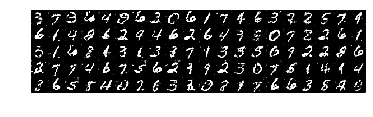

Epoch [1/25] - time: 103.90 loss_d: 1.384, loss_g: 0.639


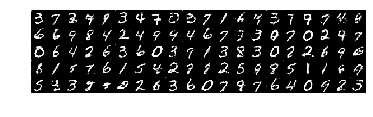

Epoch [2/25] - time: 102.13 loss_d: 1.359, loss_g: 0.647


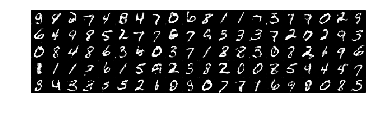

Epoch [3/25] - time: 102.12 loss_d: 1.337, loss_g: 0.640


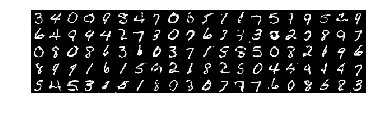

Epoch [4/25] - time: 101.95 loss_d: 1.303, loss_g: 0.637


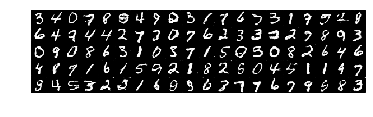

Epoch [5/25] - time: 102.18 loss_d: 1.267, loss_g: 0.631


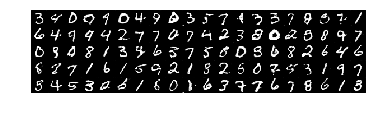

Epoch [6/25] - time: 102.02 loss_d: 1.224, loss_g: 0.623


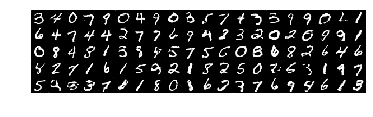

Epoch [7/25] - time: 102.14 loss_d: 1.182, loss_g: 0.616


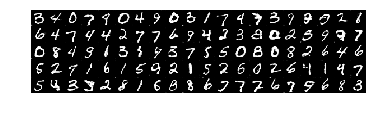

Epoch [8/25] - time: 102.26 loss_d: 1.138, loss_g: 0.613
Epoch [9/25] - time: 102.13 loss_d: 1.094, loss_g: 0.608


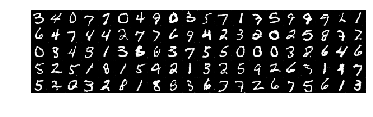

Epoch [10/25] - time: 102.00 loss_d: 1.055, loss_g: 0.603


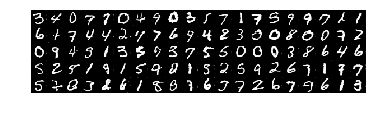

Epoch [11/25] - time: 102.14 loss_d: 1.021, loss_g: 0.596


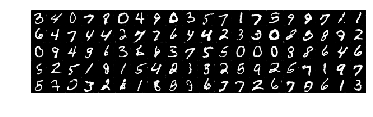

Epoch [12/25] - time: 101.72 loss_d: 0.977, loss_g: 0.592


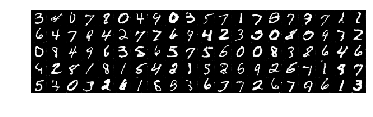

Epoch [13/25] - time: 101.74 loss_d: 0.942, loss_g: 0.593


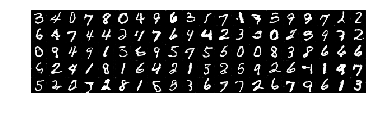

Epoch [14/25] - time: 102.17 loss_d: 0.903, loss_g: 0.598


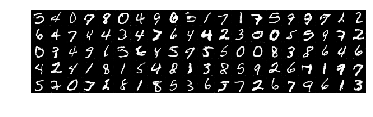

Epoch [15/25] - time: 102.07 loss_d: 0.873, loss_g: 0.595


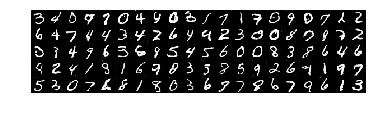

Epoch [16/25] - time: 101.96 loss_d: 0.855, loss_g: 0.587


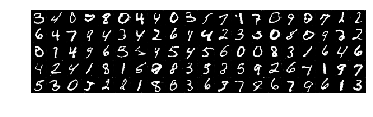

Epoch [17/25] - time: 102.21 loss_d: 0.815, loss_g: 0.600


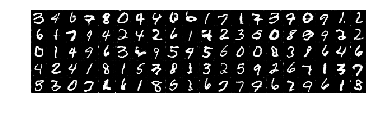

Epoch [18/25] - time: 102.11 loss_d: 0.790, loss_g: 0.607


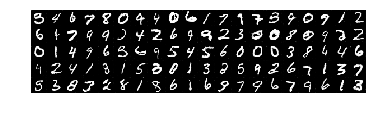

Epoch [19/25] - time: 102.18 loss_d: 0.770, loss_g: 0.605


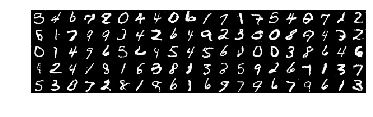

Epoch [20/25] - time: 102.05 loss_d: 0.746, loss_g: 0.612


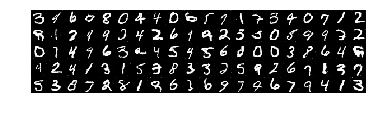

Epoch [21/25] - time: 101.98 loss_d: 0.725, loss_g: 0.612


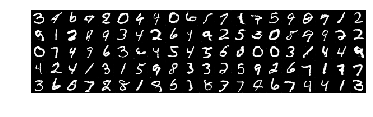

Epoch [22/25] - time: 102.11 loss_d: 0.707, loss_g: 0.619


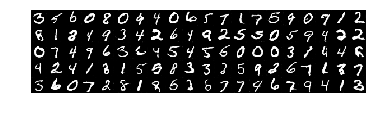

Epoch [23/25] - time: 101.99 loss_d: 0.681, loss_g: 0.611


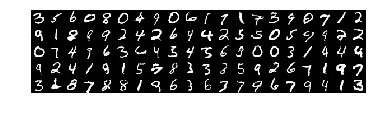

Epoch [24/25] - time: 101.93 loss_d: 0.671, loss_g: 0.619


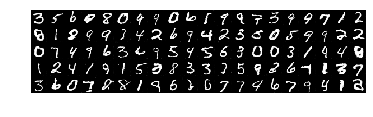

Epoch [25/25] - time: 102.42 loss_d: 0.643, loss_g: 0.624


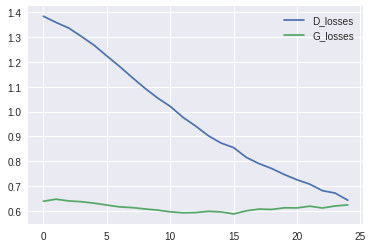

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    dcgan = DCGAN(sess, batch_size=100, image_size=28, z_dim=10)
    dcgan.train(num_epoch=25, lr=0.0002, beta1=0.5)